# Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Загрузка данных

In [2]:
df = pd.read_sas('datasets/diabetes.sas7bdat')

# Подготовка данных

In [6]:
features = df.drop(columns = ['y'])
target = df['y']

In [7]:
X_train,X_test,y_train,y_test = train_test_split(features,target,random_state = 42,test_size = 0.2)

In [8]:
kf = KFold(n_splits=2,random_state = 42,shuffle = True)

# Обучение модели

In [9]:
model = LGBMRegressor(random_state = 42)

In [10]:
score = -cross_val_score(model, X_train, y_train, cv=kf,scoring = 'neg_mean_squared_error',
                         n_jobs=-1).mean()
print(score)

4069.5211796934614


# Подбор гиперпараметров

## GridSearch

In [11]:
from sklearn.model_selection import GridSearchCV

In [12]:
param_grid={'learning_rate': np.logspace(-3, -1, 3),
            'max_depth':  np.linspace(5,12,8,dtype = int),
            'n_estimators': np.linspace(800,1200,5, dtype = int)}

In [13]:
gs=GridSearchCV(model, param_grid, scoring='neg_mean_squared_error',
                n_jobs=None, cv=kf, verbose=False)

In [14]:
%%time
gs.fit(X_train,y_train)
gs_test_score=mean_squared_error(y_test, gs.predict(X_test))

Wall time: 45.9 s


In [15]:
print("Best MSE {:.3f} params {}".format(-gs.best_score_, gs.best_params_))

Best MSE 3943.183 params {'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 1200}


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

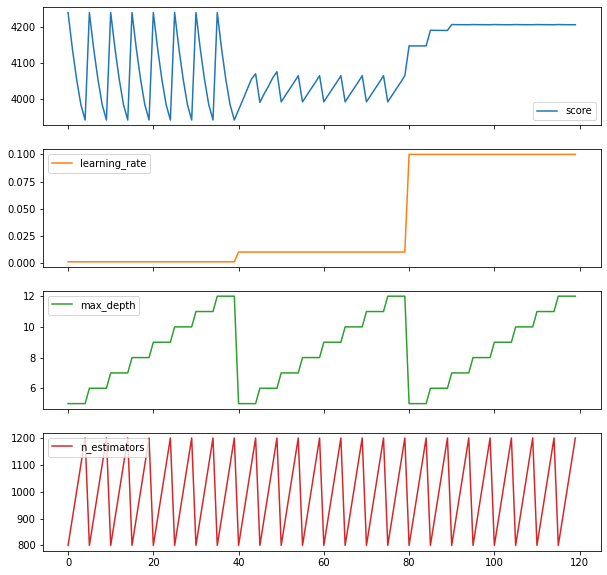

In [16]:
gs_results_df=pd.DataFrame(np.transpose([-gs.cv_results_['mean_test_score'],
                                         gs.cv_results_['param_learning_rate'].data,
                                         gs.cv_results_['param_max_depth'].data,
                                         gs.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
gs_results_df.plot(subplots=True,figsize=(10, 10))

## RandomSearch

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [18]:
param_grid_rand={'learning_rate': np.logspace(-5, 0, 100),
                 'max_depth':  randint(2,20),
                 'n_estimators': randint(100,2000)}

In [19]:
rs=RandomizedSearchCV(model, param_grid_rand, n_iter = 50, scoring='neg_mean_squared_error', 
                n_jobs=-1, cv=kf, verbose=False, random_state = 42)

In [20]:
rs.fit(X_train, y_train)
rs_test_score=mean_squared_error(y_test, rs.predict(X_test))

In [21]:
print("Best MSE {:.3f} params {}".format(-rs.best_score_, rs.best_params_))

Best MSE 3720.008 params {'learning_rate': 0.0042292428743894986, 'max_depth': 3, 'n_estimators': 443}


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

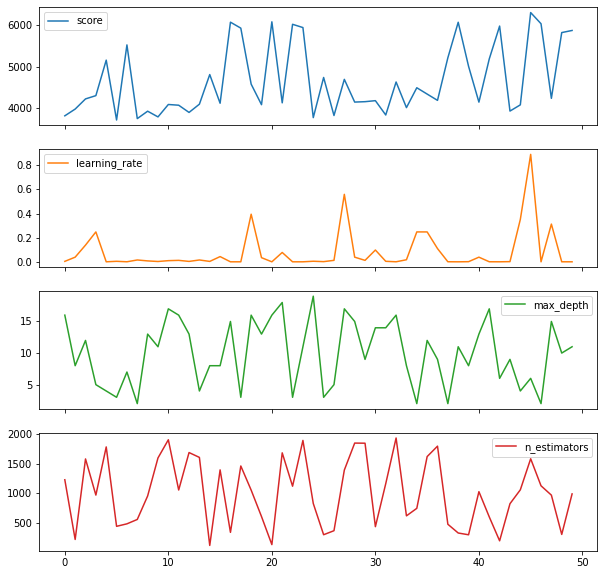

In [22]:
rs_results_df=pd.DataFrame(np.transpose([-rs.cv_results_['mean_test_score'],
                                         rs.cv_results_['param_learning_rate'].data,
                                         rs.cv_results_['param_max_depth'].data,
                                         rs.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [23]:
conda install -c conda-forge hyperopt

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\A\anaconda3

  added / updated specs:
    - hyperopt


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cloudpickle-1.6.0          |             py_0          22 KB  conda-forge
    hyperopt-0.2.5             |     pyh9f0ad1d_0         762 KB  conda-forge
    networkx-2.5               |             py_0         1.2 MB  conda-forge
    openssl-1.1.1k             |       h8ffe710_0         5.7 MB  conda-forge
    pymongo-3.11.0             |   py38h4b9bc1a_4         1.1 MB  conda-forge
    scipy-1.6.2                |   py38h14eb087_0        13.0 MB
    ------------------------------------------------------------
                                           Total:        21.8 MB

The following NEW packages will be INSTALLED:

  cloudpickle        conda-forge/noarch::cloudpickle-1.6.0-py_0
  hyperopt

In [24]:
from hyperopt import fmin, tpe, hp, anneal, Trials

In [25]:
def gb_mse_cv(params, random_state=42, cv=kf, X=X_train, y=y_train):
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'learning_rate': params['learning_rate']}
    
    # we use this params to create a new LGBM Regressor
    model = LGBMRegressor(random_state=42, **params)
    
    # and then conduct the cross validation with the same folds as before
    score = -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1).mean()

    return score

In [26]:
%%time

# possible values of parameters
space={'n_estimators': hp.quniform('n_estimators', 100, 2000, 1),
       'max_depth' : hp.quniform('max_depth', 1, 25, 1),
       'learning_rate': hp.loguniform('learning_rate', -5, 0)
      }

# trials will contain logging information
trials = Trials()

best=fmin(fn=gb_mse_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=100, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(42) # fixing random state for the reproducibility
         )

# computing the score on the test set
model = LGBMRegressor(random_state=42, n_estimators=int(best['n_estimators']),
                      max_depth=int(best['max_depth']),learning_rate=best['learning_rate'])

model.fit(X_train,y_train)

tpe_test_score=mean_squared_error(y_test, model.predict(X_test))

print("Best MSE {:.3f} params {}".format(gb_mse_cv(best), best))

100%|██████████| 100/100 [00:26<00:00,  3.82trial/s, best loss: 3474.6627296128227]
Best MSE 3474.663 params {'learning_rate': 0.011494427956221609, 'max_depth': 1.0, 'n_estimators': 665.0}
Wall time: 26.3 s


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

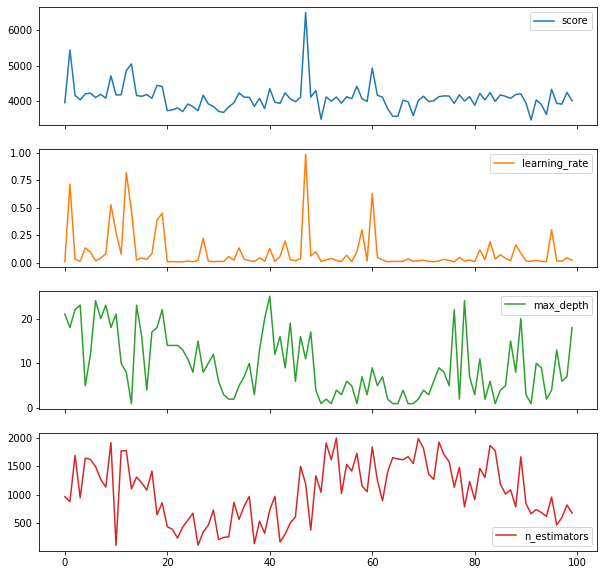

In [27]:
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['learning_rate'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
tpe_results_df.plot(subplots=True,figsize=(10, 10))

### Simulated Anneal

In [28]:
# possible values of parameters
space={'n_estimators': hp.quniform('n_estimators', 100, 2000, 1),
       'max_depth' : hp.quniform('max_depth', 2, 20, 1),
       'learning_rate': hp.loguniform('learning_rate', -5, 0)
      }

# trials will contain logging information
trials = Trials()

best=fmin(fn=gb_mse_cv, # function to optimize
          space=space, 
          algo=anneal.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=200, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.RandomState(42) # fixing random state for the reproducibility
         )

# computing the score on the test set
model = LGBMRegressor(random_state=42, n_estimators=int(best['n_estimators']),
                      max_depth=int(best['max_depth']),learning_rate=best['learning_rate'])
model.fit(X_train,y_train)
sa_test_score=mean_squared_error(y_test, model.predict(X_test))

print("Best MSE {:.3f} params {}".format(gb_mse_cv(best), best))

100%|██████████| 200/200 [00:22<00:00,  8.77trial/s, best loss: 3691.805261143505] 
Best MSE 3691.805 params {'learning_rate': 0.009627275963525866, 'max_depth': 7.0, 'n_estimators': 282.0}


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

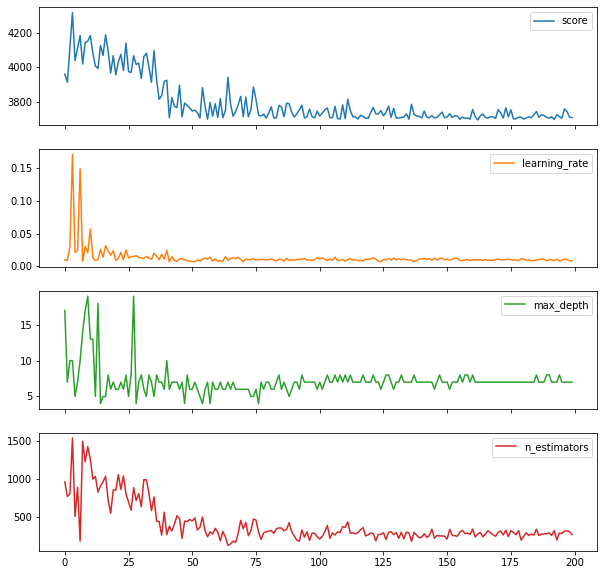

In [29]:
sa_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['learning_rate'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

sa_results_df=pd.DataFrame(sa_results,
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
sa_results_df.plot(subplots=True,figsize=(10, 10))

Text(0, 0.5, 'best_cumulative_score')

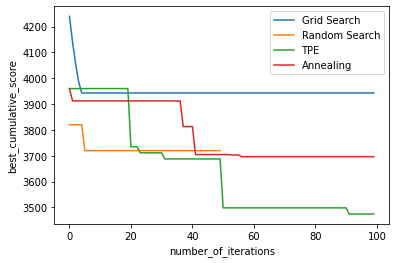

In [30]:
scores_df=pd.DataFrame(index=range(100))
scores_df['Grid Search']=gs_results_df['score'].cummin()
scores_df['Random Search']=rs_results_df['score'].cummin()
scores_df['TPE']=tpe_results_df['score'].cummin()
scores_df['Annealing']=sa_results_df['score'].cummin()

ax = scores_df.plot()

ax.set_xlabel("number_of_iterations")
ax.set_ylabel("best_cumulative_score")

In [31]:
print('Test MSE scored:')
print("Grid Search {:.3f}".format(gs_test_score))
print("Random Search {:.3f}".format(rs_test_score))
print("TPE {:.3f}".format(tpe_test_score))
print("Annealing {:.3f}".format(sa_test_score))

Test MSE scored:
Grid Search 3151.201
Random Search 2890.052
TPE 2905.093
Annealing 2868.947
